In [1]:
import pandas as pd
import dask.dataframe as dd
from dask.distributed import Client
import pyarrow as pa
import pyarrow.parquet as pq

In [2]:
# Pandas로 데이터 살펴보기
df = pd.read_csv(r"C:\Users\mylio\Desktop\cp1\archive (1)\2019-Oct.csv")
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 15.4 GB


In [3]:
# 데이터 경량화(step별 memory변화 확인)
# df.describe(include='object')
# df = df.astype({'event_type': 'category', 'category_code': 'category', 'brand': 'category'})
# df.info(memory_usage='deep')

In [4]:
# df = df.astype({'product_id': 'int32', 'price': 'float32', 'user_id': 'int32'})
# df.info(memory_usage='deep')

In [5]:
# df = df.astype({'event_time': 'datetime64'})
# df.info(memory_usage='deep') 

In [6]:
df = df.astype({'event_type': 'category', 
                'category_code': 'category', 
                'brand': 'category', 
                'product_id': 'int32', 
                'price': 'float16', 
                'user_id': 'int32', 
                'event_time': 'datetime64'})
df.info(memory_usage='deep') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42448764 entries, 0 to 42448763
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   event_type     category      
 2   product_id     int32         
 3   category_id    int64         
 4   category_code  category      
 5   brand          category      
 6   price          float16       
 7   user_id        int32         
 8   user_session   object        
dtypes: category(3), datetime64[ns](1), float16(1), int32(2), int64(1), object(1)
memory usage: 4.9 GB


In [7]:
# sum(df.user_session.value_counts() == 1)

In [8]:
# df = df.set_index(['user_id', 'user_session', 'event_time'], drop=True)
# df = df.set_index('user_id', drop=True)
# df.info(memory_usage='deep')

In [9]:
# 결측값 확인
df.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

In [10]:
# category
print("Total category_id: ", df['category_id'].nunique())
print("Total category_code: ", df['category_code'].nunique())

Total category_id:  624
Total category_code:  126


In [11]:
# top10 category_id
df.category_id.value_counts().head(10)

2053013555631882655    11507231
2053013553559896355     1888744
2053013558920217191     1130645
2053013554415534427     1105635
2053013554658804075     1100188
2053013563810775923      869404
2053013563651392361      787191
2053013565983425517      773468
2053013553341792533      706417
2053013556168753601      694553
Name: category_id, dtype: int64

In [12]:
# top 10중 첫번째 category_id의 category_code 확인
df[df['category_id'] == 2053013555631882655].category_code.unique()
# 같은 category_id라도 다른 category_code를 가질 수 있다
# category_id는 분석에 큰 의미없어 보인다
# category_code가 null의 경우 보간할 방법이 없으므로 삭제한다

['electronics.smartphone']
Categories (126, object): ['accessories.bag', 'accessories.umbrella', 'accessories.wallet', 'apparel.belt', ..., 'sport.snowboard', 'sport.tennis', 'sport.trainer', 'stationery.cartrige']

In [13]:
df = df.drop(df[df['category_code'].isnull()].index).reset_index(drop=True)
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28933155 entries, 0 to 28933154
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   event_type     category      
 2   product_id     int32         
 3   category_id    int64         
 4   category_code  category      
 5   brand          category      
 6   price          float16       
 7   user_id        int32         
 8   user_session   object        
dtypes: category(3), datetime64[ns](1), float16(1), int32(2), int64(1), object(1)
memory usage: 3.3 GB


In [14]:
# user_session 결측값 확인
df[df['user_session'].isnull()]

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
4935734,2019-10-06 14:26:10,cart,1801723,2053013554415534427,electronics.video.tv,tcl,135.625,557388939,NaN
23100158,2019-10-25 10:36:14,cart,1004767,2053013555631882655,electronics.smartphone,samsung,246.500,549825742,NaN


In [15]:
# user_session 결측값 두 개 중 한 개의 user_id로 데이터 확인
df[df['user_id'] == 557388939]
# 특별한 이유가 있어 null이 된 것으로 보이지 않고 단순 오류일 가능성
# 삭제 처리한다
df = df.drop(df[df['user_id'].isnull()].index).reset_index(drop=True)

In [16]:
df.isnull().sum()

event_time             0
event_type             0
product_id             0
category_id            0
category_code          0
brand            2372533
price                  0
user_id                0
user_session           2
dtype: int64

In [17]:
df.memory_usage(deep=True)

Index                   128
event_time        231465240
event_type         28933450
product_id        115732620
category_id       231465240
category_code      28947380
brand              58217775
price              57866310
user_id           115732620
user_session     2690783293
dtype: int64

In [18]:
# df.to_parquet('oct19.parquet')
# df_dd = dd.read_parquet('*.parquet')

[Text(0, 0, '0.951951'), Text(0, 0, '0.0283685'), Text(0, 0, '0.0196807')]

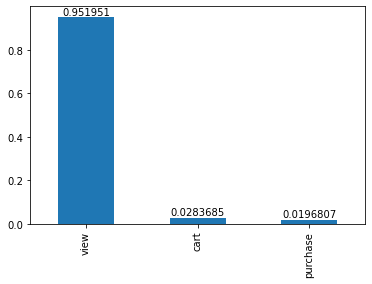

In [19]:
import matplotlib.pylab as plt
import seaborn as sns
#%%
# event_type 분포 확인
events = df['event_type'].value_counts(normalize=True).plot(kind='bar')
events.bar_label(events.containers[0])
# events.plot(kind='bar')

In [20]:
# brand 개수 및 분포 확인
print("Total brand: ", df['brand'].nunique())
df['brand'].value_counts(normalize=True).head(10)
# 그림 그려보고 상위 브랜드 분석

Total brand:  1731


samsung    0.194231
apple      0.154087
xiaomi     0.101566
huawei     0.041127
lg         0.019164
oppo       0.018181
acer       0.016117
lenovo     0.012724
bosch      0.012418
hp         0.011108
Name: brand, dtype: float64

<AxesSubplot:>

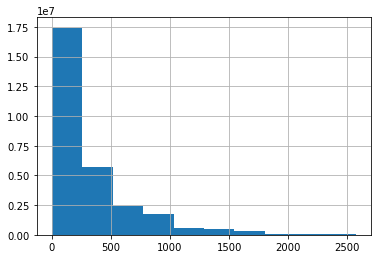

In [21]:
# price 분포 확인
df.price.hist()

In [22]:
# price == 0 삭제
print(len(df[df['price'] == 0]))
df = df.drop(df[df['price'] == 0.0].index).reset_index(drop=True)
df.info(memory_usage='deep')

31625
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28901530 entries, 0 to 28901529
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   event_type     category      
 2   product_id     int32         
 3   category_id    int64         
 4   category_code  category      
 5   brand          category      
 6   price          float16       
 7   user_id        int32         
 8   user_session   object        
dtypes: category(3), datetime64[ns](1), float16(1), int32(2), int64(1), object(1)
memory usage: 3.3 GB


<AxesSubplot:>

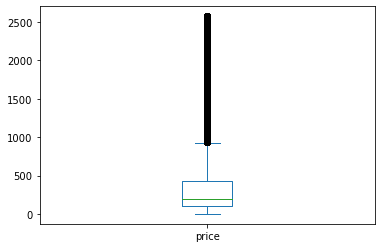

In [23]:
df.price.plot(kind='box')

In [24]:
df[df['price'] > 800]
# 확인결과 고가의 전자기기 케이스, 10%비중으로 이상치로 판단할 수 없다
len(df[df['price'] > 800])/len(df)

0.1082447538244515

In [25]:
len(df[df['price'] > 250])/len(df)
# 저가 상품이 전체 판매상품의 40% 이상
# 가설1. 저가 상품이 가장 많이 팔리고 있을 것이다.

0.4239529187555123

In [26]:
# dask
# client = Client()
# client
df_dd = dd.read_csv(r"C:\Users\mylio\Desktop\cp1\archive (1)\2019-Oct.csv", dtype=(
    {'event_type': 'category', 'category_code': 'category', 'brand': 'category', 
     'product_id': 'int32', 'price': 'float32', 'user_id': 'int32'}), 
     parse_dates=['event_time'])
df_dd.dtypes
# 데이터크기가 너무 커서 연산속도보다는 메모리 용량부족이 문제라 해결책이 되지 않는다
# 분석대상에 따라 데이터를 쪼개서 분석하도록 한다

event_time       datetime64[ns, UTC]
event_type                  category
product_id                     int32
category_id                    int64
category_code               category
brand                       category
price                        float32
user_id                        int32
user_session                  object
dtype: object

In [27]:
df_dd.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00+00:00,view,44600062,2103807459595387724,NaN,shiseido,35.790001,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00+00:00,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.200001,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01+00:00,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.099976,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01+00:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.740005,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04+00:00,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.979980,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [28]:
# 구매를 한번이라도 해본 고객을 대상으로 고객행동분석
df[df.event_type == 'purchase'].user_id.nunique()

272071

In [31]:
user_df = df[df['user_id'].isin(df[df.event_type == 'purchase'].user_id.unique())]
user_df

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
4,2019-10-01 00:00:05,view,1480613,2053013561092866779,computers.desktop,pulser,908.500,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
17,2019-10-01 00:00:22,view,1480714,2053013561092866779,computers.desktop,pulser,921.500,512742880,0d0d91c2-c9c2-4e81-90a5-86594dec0db9
18,2019-10-01 00:00:23,view,1004739,2053013555631882655,electronics.smartphone,xiaomi,197.500,519530528,9882d21f-2c5f-496b-90d4-a1503edb6562
31,2019-10-01 00:00:35,view,3601505,2053013563810775923,appliances.kitchen.washer,samsung,463.250,526631741,5ec9bd77-beef-443e-b987-62ffb55b8132
32,2019-10-01 00:00:36,view,3600575,2053013563810775923,appliances.kitchen.washer,hotpoint-ariston,275.250,554754045,bd0302ef-c5ca-4b6a-b916-95cc2840c72c
...,...,...,...,...,...,...,...,...,...
28901501,2019-10-31 23:59:44,view,4804056,2053013554658804075,electronics.audio.headphone,apple,160.625,544501248,e330d051-37ad-4dc3-b1ee-ff16a28b7998
28901508,2019-10-31 23:59:49,view,1307449,2053013558920217191,computers.notebook,asus,2570.000,513741043,82f7f972-346a-41f1-ae58-3ccf1edf6726
28901510,2019-10-31 23:59:51,view,1005014,2053013555631882655,electronics.smartphone,samsung,503.000,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a
28901514,2019-10-31 23:59:52,view,1002524,2053013555631882655,electronics.smartphone,apple,531.500,565404816,d9cf0ac4-c3ec-4e1f-83aa-326b1e7b1581


In [ ]:
# sql DB에 저장 후 태블로 활용 및 별도로 분석
import sqlite3
db = r"C:\Users\mylio\Desktop\cp1\cp1.db"
con = sqlite3.connect(db)
user_df.to_sql('user_table', con)